# Pearson's correlation coefficient

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../../notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" target="_blank">
        <img class="button-icon" src="../../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
# ]
# ///

## Description

In this section, we will explore how to implement in Python the **Mander's Correlation Coefficients** and the **Pearson's Correlation Coefficients**, which are two common methods for quantifying colocalization based on pixel intensities.

```{warning}
NOTE: this notebook aims to show how to practically implement these methods but does not aim to describe when to use which method. The images used have been selected to showcase the practical implementation of the methods.
```

### import libraries

In [50]:
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy.stats import linregress, pearsonr
from skimage.filters import threshold_otsu

## Mander's Correlation Coefficients

Mander's correlation coefficients are a measure of colocalization that is based on the pixel intensities of two channels.

...

Mander's is extremely sensitive to thresholding, so the way you decide to threshold your images will have a large impact on the results.

<!-- <div align="left"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/manders_slide.png" alt="Ilastik Logo" width="800"></div> -->
<div align="left"> <img src="../../_static/images/coloc/manders_slide.png" alt="Ilastik Logo" width="800"></div>


### open an image and visualize it with ndv

In [3]:
# open the image
img_path = "../../_static/images/coloc/14na_z4.tif"
img = tifffile.imread(img_path)

In [ ]:
# visualize the image
ndv.imshow(img)

In [ ]:
viewer = ndv.imshow(img)

In [ ]:
viewer.widget().children[1].snapshot()

To compute Mander's Correlation Coefficients, we need **two separate images** (channels). 

What is the image shape? How do we split the channels?

In [4]:
# get image shape
print("Image shape:", img.shape)

Image shape: (2, 512, 512)


In [ ]:
# split the image into channels
ch1 = img[0]
ch2 = img[1]

The first and key step is to select which areas of each channel we want to consider for the colocalization analysis. This means we first need to threshold each images to select only the pixels we want to consider for the analysis.

<!-- <div align="left"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/manders.png" alt="Ilastik Logo" width="500"></div> -->
<div align="left"> <img src="../../_static/images/coloc/manders.png" alt="Ilastik Logo" width="500"></div>

```{warning}
    Mander's Correlation Coefficients are extremely sensitive to thresholding, so the way you decide to threshold your images will have a large impact on the results. In this example we will use a simple Otsu thresholding method, but before running a real analysis, you should carefully consider how to threshold your images. In addition, more image processing steps might be needed to clean the images before computing the Mander's Correlation Coefficients such as background subtraction, flat-field correction, etc.
```


### Costes auto-threshold function

In [ ]:
def costes_auto_threshold(
    ch1: np.ndarray,
    ch2: np.ndarray,
    num_thresholds: int = 100,
):
    """
    Implementation of Costes auto-threshold method for colocalization analysis.

    Based on:
    Costes et al. "Automatic and quantitative measurement of protein-protein
    colocalization in live cells" Biophysical Journal 2004
    https://pmc.ncbi.nlm.nih.gov/articles/PMC1304300/

    The method finds thresholds where the Pearson correlation coefficient
    of pixels below the thresholds equals zero, indicating that pixels
    below these thresholds show no statistical correlation.

    Parameters
    -----------
    ch1: np.ndarray
        First channel image data (2D array).
    ch2: np.ndarray
        Second channel image data (2D array).
    num_thresholds: int
        Number of threshold values to test along the regression line. By default, 100.

    Returns
    ------
    tuple: (threshold_ch1, threshold_ch2, correlation_above_threshold)
    """

    # Flatten images for easier processing
    ch1_flat = ch1.flatten()
    ch2_flat = ch2.flatten()

    # If the min value is zero, consider only non-zero pixels
    if np.min(ch1_flat) == 0 or np.min(ch2_flat) == 0:
        mask = (ch1_flat > 0) & (ch2_flat > 0)
        ch1_masked = ch1_flat[mask]
        ch2_masked = ch2_flat[mask]
    else:
        ch1_masked = ch1_flat
        ch2_masked = ch2_flat

    if len(ch1_masked) == 0 or len(ch2_masked) == 0:
        return 0, 0, 0

    # Perform linear regression to find the relationship between channels
    # This gives us the line IG = a * IR + b
    slope, intercept, r_value, p_value, std_err = linregress(ch1_masked, ch2_masked)

    # Create threshold pairs along the regression line
    # Choose iteration strategy based on slope and dynamic range for better numerical stability
    max_ch1, max_ch2 = np.max(ch1_masked), np.max(ch2_masked)
    min_ch1, min_ch2 = np.min(ch1_masked), np.min(ch2_masked)

    range_ch1 = max_ch1 - min_ch1
    range_ch2 = max_ch2 - min_ch2

    best_the_ch1 = best_the_ch2 = 0
    best_correlation = 1.0

    # Choose which channel to iterate over based on:
    # 1. Slope magnitude (for numerical stability)
    # 2. Dynamic range (for better sampling)
    use_ch1_as_driver = True

    # is the slope steep, iterate over ch2 for stability
    if abs(slope) > 1.5:
        use_ch1_as_driver = False
    # elif slope is shallow, iterate over ch1 for stability
    elif abs(slope) < 0.67:
        use_ch1_as_driver = True
    # otherwise use channel with larger range dynamic range
    else:
        use_ch1_as_driver = range_ch1 >= range_ch2

    if use_ch1_as_driver:
        # Iterate over ch1 thresholds, calculate ch2 from regression
        threshold_values = np.linspace(max_ch1, min_ch1, num_thresholds)

        for the_ch1 in threshold_values:
            the_ch2 = slope * the_ch1 + intercept

            # Create mask for pixels below thresholds
            below_mask = (ch1_masked < the_ch1) & (ch2_masked < the_ch2)

            if np.sum(below_mask) < 10:  # Need minimum number of pixels
                continue

            # Calculate correlation for pixels below threshold
            ch1_below = ch1_masked[below_mask]
            ch2_below = ch2_masked[below_mask]

            if len(ch1_below) > 1 and np.std(ch1_below) > 0 and np.std(ch2_below) > 0:
                correlation, _ = pearsonr(ch1_below, ch2_below)

                # Find threshold where correlation is closest to zero
                if abs(correlation) < abs(best_correlation):
                    best_correlation = correlation
                    best_the_ch1 = the_ch1
                    best_the_ch2 = the_ch2

    else:
        # Iterate over ch2 thresholds, calculate ch1 from regression
        threshold_values = np.linspace(max_ch2, min_ch2, num_thresholds)

        for the_ch2 in threshold_values:
            # Solve for ch1: ch1 = (ch2 - intercept) / slope
            if abs(slope) > 1e-10:  # Avoid division by zero
                the_ch1 = (the_ch2 - intercept) / slope
            else:
                continue

            # Create mask for pixels below thresholds
            below_mask = (ch1_masked < the_ch1) & (ch2_masked < the_ch2)

            if np.sum(below_mask) < 10:  # Need minimum number of pixels
                continue

            # Calculate correlation for pixels below threshold
            ch1_below = ch1_masked[below_mask]
            ch2_below = ch2_masked[below_mask]

            if len(ch1_below) > 1 and np.std(ch1_below) > 0 and np.std(ch2_below) > 0:
                correlation, _ = pearsonr(ch1_below, ch2_below)

                # Find threshold where correlation is closest to zero
                if abs(correlation) < abs(best_correlation):
                    best_correlation = correlation
                    best_the_ch1 = the_ch1
                    best_the_ch2 = the_ch2

    # Calculate correlation for pixels above the optimal thresholds
    above_mask = (ch1_masked >= best_the_ch1) & (ch2_masked >= best_the_ch2)

    if np.sum(above_mask) > 1:
        ch1_above = ch1_masked[above_mask]
        ch2_above = ch2_masked[above_mask]
        if np.std(ch1_above) > 0 and np.std(ch2_above) > 0:
            correlation_above, _ = pearsonr(ch1_above, ch2_above)
        else:
            correlation_above = 0
    else:
        correlation_above = 0

    return best_the_ch1, best_the_ch2, correlation_above

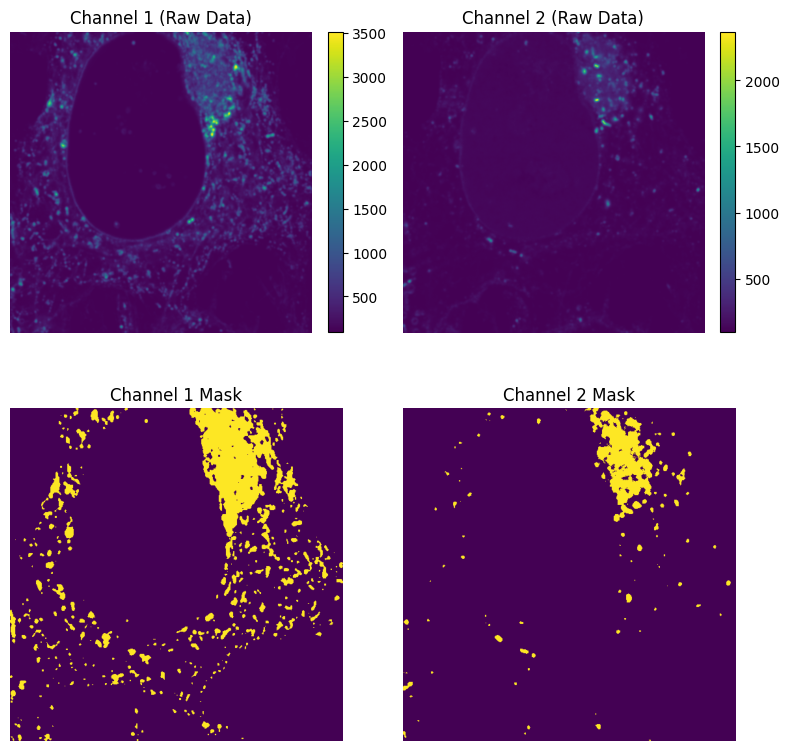

In [ ]:
# create binary masks based on thresholds
image_1_mask = ch1 > threshold_otsu(ch1)
image_2_mask = ch2 > threshold_otsu(ch2)

# plot raw data and masks in a 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Raw channel 1
im1 = ax[0, 0].imshow(ch1)
ax[0, 0].set_title("Channel 1 (Raw Data)")
ax[0, 0].axis("off")
plt.colorbar(im1, ax=ax[0, 0], fraction=0.045)

# Raw channel 2
im2 = ax[0, 1].imshow(ch2)
ax[0, 1].set_title("Channel 2 (Raw Data)")
ax[0, 1].axis("off")
plt.colorbar(im2, ax=ax[0, 1], fraction=0.045)

# Channel 1 mask
ax[1, 0].imshow(image_1_mask)
ax[1, 0].set_title("Channel 1 Mask")
ax[1, 0].axis("off")

# Channel 2 mask
ax[1, 1].imshow(image_2_mask)
ax[1, 1].set_title("Channel 2 Mask")
ax[1, 1].axis("off")

plt.tight_layout()
plt.show()

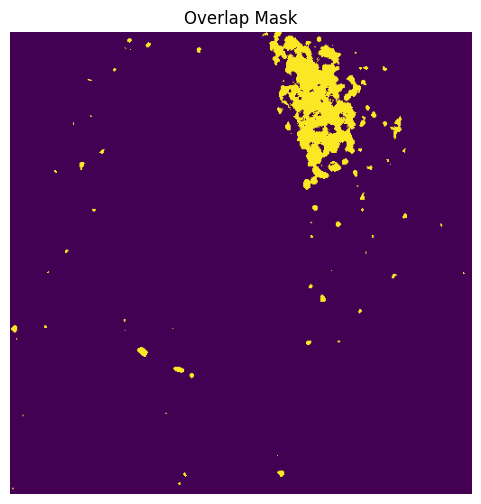

In [23]:
# only consider pixels within the mask (keep intensities above threshold, zero elsewhere)
ch1_tr = np.where(image_1_mask, ch1, 0)
ch2_tr = np.where(image_2_mask, ch2, 0)

# get the overlap mask
overlap_mask = image_1_mask & image_2_mask

# plot overlap mask
plt.figure(figsize=(6, 6))
plt.imshow(overlap_mask)
plt.title("Overlap Mask")
plt.axis("off")
plt.show()

<!-- <div align="left"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/manders.png" alt="Ilastik Logo" width="500"></div> -->
<div align="left"> <img src="../../_static/images/coloc/manders.png" alt="Ilastik Logo" width="500"></div>

In [24]:
# extract intensity from channel 1 only at pixels where both channels overlap
ch1_overlap_with_ch2 = ch1[overlap_mask]
# extract intensity from channel 2 only at pixels where both channels overlap
ch2_overlap_with_ch1 = ch2[overlap_mask]

# calculate the sum of the masked images
sum_ch1_tr = np.sum(ch1_tr)
sum_ch2_tr = np.sum(ch2_tr)

# calculate the Manders coefficients
M1 = np.sum(ch1_overlap_with_ch2) / sum_ch1_tr
M2 = np.sum(ch2_overlap_with_ch1) / sum_ch2_tr

print(f"Manders coefficient M1: {M1:.4f}")
print(f"Manders coefficient M2: {M2:.4f}")

Manders coefficient M1: 0.3496
Manders coefficient M2: 0.8975


In [25]:
# # USE NUMPY WHERE TO GET OVERLAP INTENSITIES

# # only consider pixels within the mask (keep intensities above threshold, zero elsewhere)
# ch1_tr = np.where(image_1_mask, ch1, 0)
# ch2_tr = np.where(image_2_mask, ch2, 0)

# # find overlapping regions
# # use intensity values from ch1 (above threshold) ONLY where ch2 > 0
# ch1_overlap_with_ch2 = np.where(image_2_mask, ch1_tr, 0)
# # use intensity values from ch2 (above threshold) ONLY where ch1 > 0
# ch2_overlap_with_ch1 = np.where(image_1_mask, ch2_tr, 0)

# # calculate the sum of the masked images
# sum_ch1_tr = np.sum(ch1_tr)
# sum_ch2_tr = np.sum(ch2_tr)

# # calculate the Manders coefficients
# M1 = np.sum(ch1_overlap_with_ch2) / sum_ch1_tr
# M2 = np.sum(ch2_overlap_with_ch1) / sum_ch2_tr

# print(f"Manders coefficient M1: {M1:.4f}")
# print(f"Manders coefficient M2: {M2:.4f}")

## Pearson's Correlation Coefficient
<!-- <div align="center"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/pearsons.png" alt="Ilastik Logo" width="600"></div> -->
<div align="left"> <img src="../../_static/images/coloc/pearsons.png" alt="Ilastik Logo" width="600"></div>

In [ ]:
# plot scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(ch1.flatten(), ch2.flatten(), s=1, alpha=0.5)
plt.xlabel("Image 1 Intensity")
plt.ylabel("Image 2 Intensity")
plt.title("Scatter Plot of Pixel Intensities")
# set both axes to the same range based on the maximum value
max_intensity = max(ch1.max(), ch2.max())
plt.xlim(0, max_intensity)
plt.ylim(0, max_intensity)
plt.show()

In [ ]:
mean_ch1 = np.mean(ch1)
mean_ch2 = np.mean(ch2)

numerator = np.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
denominator = np.sqrt(np.sum((ch1 - mean_ch1) ** 2) * np.sum((ch2 - mean_ch2) ** 2))
prs = numerator / denominator
print(f"Pearson's correlation coefficient: {prs:.4f}")

pearson, p_value = pearsonr(ch1.flatten(), ch2.flatten())
print(
    f"Pearson's correlation coefficient (scipy): {pearson:.4f}, p-value: {p_value:.4f}"
)

In [ ]:
# calculate pearsons on thresholded images

# image_1_mask = ch1 > threshold_otsu(ch1)
# image_2_mask = ch2 > threshold_otsu(ch2)
image_1_mask = ch1 > 1000
image_2_mask = ch2 > 1000

# get the overlap mask
overlap_mask = image_1_mask & image_2_mask

# extract intensity from channel 1 only at pixels where both channels overlap
image_1_masked = ch1[overlap_mask]
# extract intensity from channel 2 only at pixels where both channels overlap
image_2_masked = ch2[overlap_mask]

# plot scatter plot for masked images
plt.figure(figsize=(6, 6))
plt.scatter(image_1_masked.flatten(), image_2_masked.flatten(), s=1, alpha=0.5)
plt.xlabel("Image 1 Intensity (Masked)")
plt.ylabel("Image 2 Intensity (Masked)")
plt.title("Scatter Plot of Masked Pixel Intensities")
# set both axes to the same range based on the maximum value of the masked images
max_intensity_masked = max(image_1_masked.max(), image_2_masked.max())
min_intensity_masked = min(image_1_masked.min(), image_2_masked.min())
plt.xlim(min_intensity_masked, max_intensity_masked)
plt.ylim(min_intensity_masked, max_intensity_masked)
plt.show()

mean_ch1_masked = np.mean(image_1_masked)
mean_ch2_masked = np.mean(image_2_masked)

numerator_masked = np.sum(
    (image_1_masked - mean_ch1_masked) * (image_2_masked - mean_ch2_masked)
)
denominator_masked = np.sqrt(
    np.sum((image_1_masked - mean_ch1_masked) ** 2)
    * np.sum((image_2_masked - mean_ch2_masked) ** 2)
)
prs_masked = numerator_masked / denominator_masked
print(f"Pearson's correlation coefficient (masked): {prs_masked:.4f}")

# Verify with scipy's pearsonr on the same masked data
pearson_masked_scipy, p_value_masked = pearsonr(image_1_masked, image_2_masked)
print(
    f"Pearson's correlation coefficient (masked, scipy): {pearson_masked_scipy:.4f}, p-value: {p_value_masked:.4f}"
)

Costes Auto-Threshold Results:
Channel 1 threshold: 338.0
Channel 2 threshold: 156.8
Pearson correlation above thresholds: 0.2483

Manders coefficients with Costes thresholds:
M1 (Costes): 0.5913
M2 (Costes): 0.7902


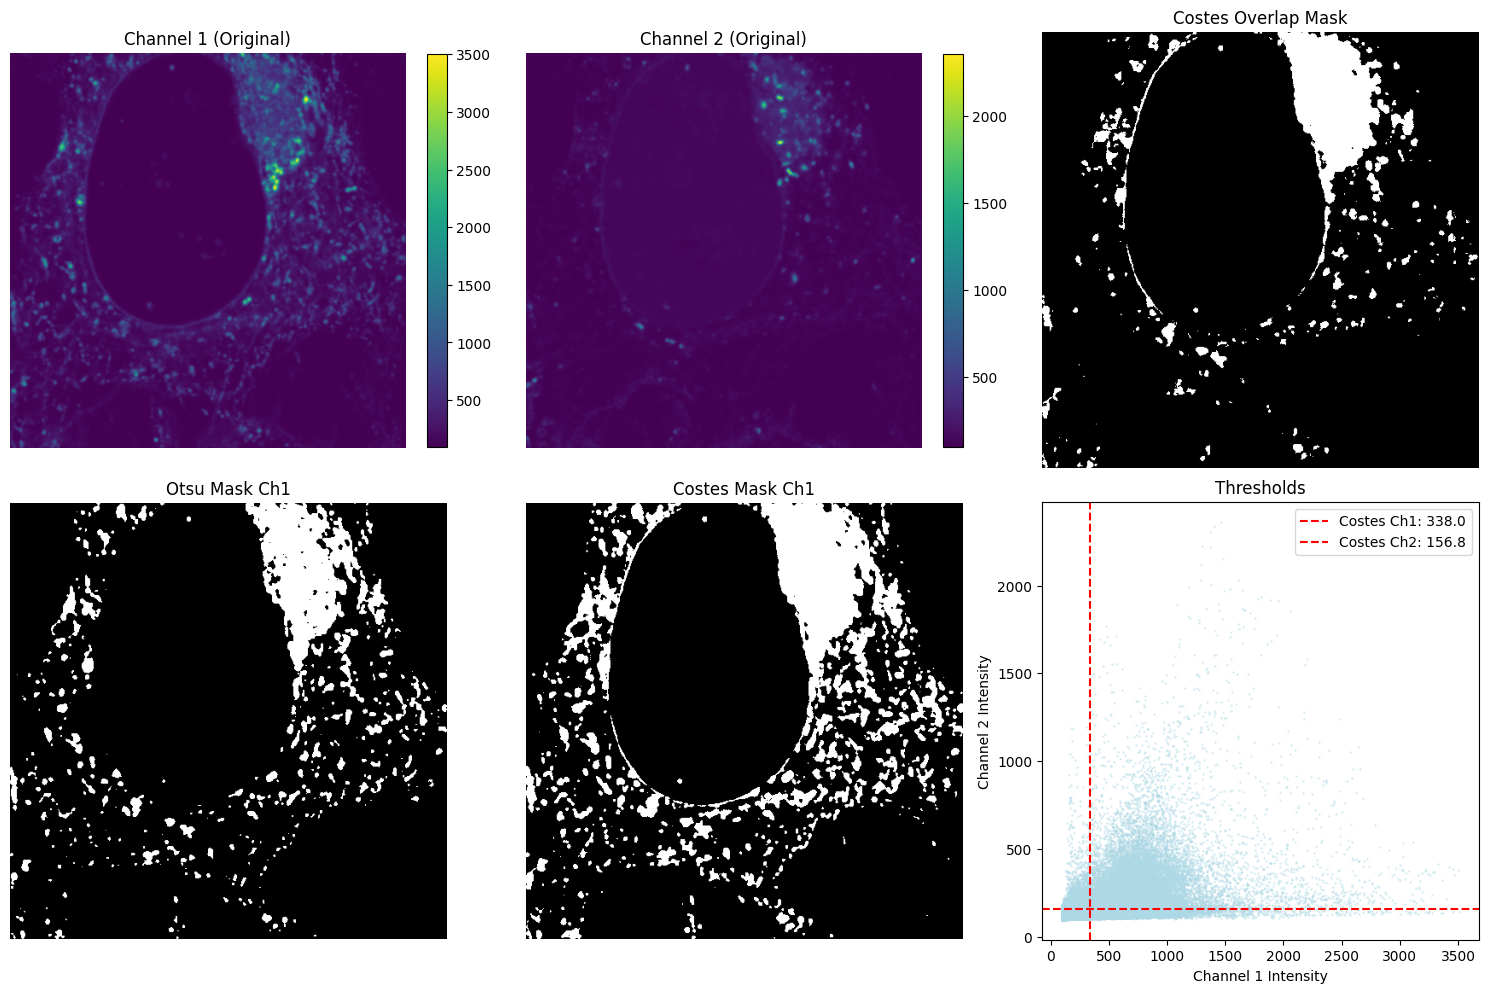

In [ ]:
# Apply Costes auto-threshold to our data
costes_thr_ch1, costes_the_ch2, correlation_above = costes_auto_threshold(ch1, ch2)

print("Costes Auto-Threshold Results:")
print(f"Channel 1 threshold: {costes_thr_ch1:.1f}")
print(f"Channel 2 threshold: {costes_the_ch2:.1f}")
print(f"Pearson correlation above thresholds: {correlation_above:.4f}")

# Create binary masks using Costes thresholds
costes_mask_ch1 = ch1 > costes_thr_ch1
costes_mask_ch2 = ch2 > costes_the_ch2
costes_overlap_mask = costes_mask_ch1 & costes_mask_ch2

# Calculate Manders coefficients using Costes thresholds
ch1_costes_the = np.where(costes_mask_ch1, ch1, 0)
ch2_costes_the = np.where(costes_mask_ch2, ch2, 0)

# Extract intensities in overlap regions
ch1_overlap_costes = ch1[costes_overlap_mask]
ch2_overlap_costes = ch2[costes_overlap_mask]

# Calculate Manders coefficients
sum_ch1_costes = np.sum(ch1_costes_the)
sum_ch2_costes = np.sum(ch2_costes_the)

M1_costes = np.sum(ch1_overlap_costes) / sum_ch1_costes if sum_ch1_costes > 0 else 0
M2_costes = np.sum(ch2_overlap_costes) / sum_ch2_costes if sum_ch2_costes > 0 else 0

print("\nManders coefficients with Costes thresholds:")
print(f"M1 (Costes): {M1_costes:.4f}")
print(f"M2 (Costes): {M2_costes:.4f}")

# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original images
axes[0, 0].imshow(ch1)
axes[0, 0].set_title("Channel 1 (Original)")
axes[0, 0].axis("off")
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0], fraction=0.045)

axes[0, 1].imshow(ch2)
axes[0, 1].set_title("Channel 2 (Original)")
axes[0, 1].axis("off")
plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1], fraction=0.045)

# Costes thresholded masks
axes[0, 2].imshow(costes_overlap_mask, cmap="gray")
axes[0, 2].set_title("Costes Overlap Mask")
axes[0, 2].axis("off")

# Comparison with Otsu thresholds
axes[1, 0].imshow(image_1_mask, cmap="gray")
axes[1, 0].set_title("Otsu Mask Ch1")
axes[1, 0].axis("off")

axes[1, 1].imshow(costes_mask_ch1, cmap="gray")
axes[1, 1].set_title("Costes Mask Ch1")
axes[1, 1].axis("off")

# Scatter plot showing thresholds
axes[1, 2].scatter(ch1.flatten(), ch2.flatten(), s=1, alpha=0.3, c="lightblue")
axes[1, 2].axvline(
    x=costes_thr_ch1,
    color="red",
    linestyle="--",
    label=f"Costes Ch1: {costes_thr_ch1:.1f}",
)
axes[1, 2].axhline(
    y=costes_the_ch2,
    color="red",
    linestyle="--",
    label=f"Costes Ch2: {costes_the_ch2:.1f}",
)
axes[1, 2].set_xlabel("Channel 1 Intensity")
axes[1, 2].set_ylabel("Channel 2 Intensity")
axes[1, 2].set_title("Thresholds")
axes[1, 2].legend()

plt.tight_layout()
plt.show()